<a href="https://colab.research.google.com/github/gowrishankarj/customer-conversion-prediction/blob/main/Customer_Purchase_Probability_Persona_Classifier_Lifetimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Set Current working directory
%cd '/content/drive/My Drive/FourthBrain/Capstone Project'

/content/drive/My Drive/FourthBrain/Capstone Project


In [3]:
!pip install awscli
!pip install fsspec
!pip install s3fs
!pip install squarify

  Using cached botocore-1.23.5-py3-none-any.whl (8.1 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.20.106
    Uninstalling botocore-1.20.106:
      Successfully uninstalled botocore-1.20.106
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 1.4.2 requires botocore<1.20.107,>=1.20.106, but you have botocore 1.23.5 which is incompatible.
  Using cached botocore-1.20.106-py2.py3-none-any.whl (7.7 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.23.5
    Uninstalling botocore-1.23.5:
      Successfully uninstalled botocore-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.22.5 requires botocore==1.23.5, but you have botocore 1.20.106 which is incompat

In [4]:
!pip install xlrd
!pip install lifetimes==0.10.1
!pip install nbconvert

  Using cached Lifetimes-0.10.1-py3-none-any.whl (581 kB)
  Attempting uninstall: lifetimes
    Found existing installation: Lifetimes 0.11.3
    Uninstalling Lifetimes-0.11.3:
      Successfully uninstalled Lifetimes-0.11.3


In [5]:
import os

#Set Env variables for Spark Initialization
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/My Drive/FourthBrain/Capstone Project/spark-3.2.0-bin-hadoop3.2"

#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q http://apache.osuosl.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
#!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install --upgrade --no-deps git+https://github.com/CamDavidsonPilon/lifetimes.git

  Cloning https://github.com/CamDavidsonPilon/lifetimes.git to /tmp/pip-req-build-sjsmhckc
  Running command git clone -q https://github.com/CamDavidsonPilon/lifetimes.git /tmp/pip-req-build-sjsmhckc
  Created wheel for Lifetimes: filename=Lifetimes-0.11.3-py3-none-any.whl size=584881 sha256=415f1480b8047a4eb61a8ad1e6ded5f371bb21fb69649260c562fcd2b2ff161a
  Stored in directory: /tmp/pip-ephem-wheel-cache-c76c8fe3/wheels/6c/f5/6a/09e6ed3657132c462bca7fe6bbd977178d35962efffeddb1e0
Successfully built Lifetimes
  Attempting uninstall: Lifetimes
    Found existing installation: Lifetimes 0.10.1
    Uninstalling Lifetimes-0.10.1:
      Successfully uninstalled Lifetimes-0.10.1


In [6]:
import numpy as np
import datetime as dt
import pandas as pd
import numpy as np

from numpy import asarray
from datetime import datetime
import matplotlib.pyplot as plt
import squarify
import findspark
findspark.init()

import pyspark.pandas as ps
import pyspark
import random
from pyspark.sql import SparkSession

import lifetimes
from datetime import timedelta



from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics

from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [7]:
!export AWS_SHARED_CREDENTIALS_FILE=/content/drive/MyDrive/config/awscli.ini

path = "/content/drive/MyDrive/config/awscli.ini"
os.environ['AWS_SHARED_CREDENTIALS_FILE'] = path
print(os.environ['AWS_SHARED_CREDENTIALS_FILE'])

/content/drive/MyDrive/config/awscli.ini


In [8]:
spark = SparkSession.builder.master("local[*]").getOrCreate()


In [9]:
events_data_featurized = pd.read_csv('s3://2021-july-mle-groupby-team/events-feature-enriched/events_data_clean_persona.csv')
#events_data_featurized = ps.from_pandas(events_data_featurized)
events_data_featurized.head()
events_data_featurized.columns

Index(['Unnamed: 0', 'event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session',
       'event_date', 'index', 'Recency', 'Frequency', 'Monetary',
       'Customer_Persona'],
      dtype='object')

In [10]:
current_date = datetime.strptime( events_data_featurized['event_date'].max(),'%Y-%m-%d').date()
print(current_date)

2020-01-31


In [15]:
# calculate the required customer metrics
metrics_pd = (
  lifetimes.utils.summary_data_from_transaction_data(
    events_data_featurized,
    customer_id_col='user_id',
    datetime_col='event_date',
    observation_period_end = current_date, 
    monetary_value_col ='price',
    freq='D'
    )
  )

metrics_pd.head(20)

,frequency,recency,T,monetary_value
user_id,,,,
465496,0.0,0.0,17.0,0.000000
4661182,0.0,0.0,3.0,0.000000
6217356,0.0,0.0,16.0,0.000000
9582366,0.0,0.0,12.0,0.000000
10280338,1.0,4.0,19.0,76.030000
11253733,0.0,0.0,1.0,0.000000
12936739,0.0,0.0,14.0,0.000000
12961898,4.0,14.0,18.0,68.192500
13898969,1.0,7.0,22.0,11.730000


In [18]:
# define a notebook parameter making holdout days configurable (90-days default)
holdout_days = 5 #@param {allow-input: true}
calibration_end_date = current_date - timedelta(days = holdout_days)

# calculate the required customer metrics
metrics_cal_pd = (
  lifetimes.utils.calibration_and_holdout_data(
    events_data_featurized,
    customer_id_col='user_id',
    datetime_col='event_date',
    observation_period_end = current_date,
    calibration_period_end=calibration_end_date,
    monetary_value_col ='price',
    freq='D'    
    )
  )

# display first few rows
metrics_cal_pd['duration_holdout'] = holdout_days
metrics_cal_pd.describe()
metrics_cal_pd.head(10)


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
user_id,,,,,,,
465496,0.0,0.0,12.0,0.000000,0.0,0.000000,5
6217356,0.0,0.0,11.0,0.000000,0.0,0.000000,5
9582366,0.0,0.0,7.0,0.000000,0.0,0.000000,5
10280338,1.0,4.0,14.0,76.030000,0.0,0.000000,5
12936739,0.0,0.0,9.0,0.000000,0.0,0.000000,5
12961898,3.0,8.0,13.0,64.786667,1.0,2.904074,5
13898969,1.0,7.0,17.0,11.730000,0.0,0.000000,5
16460232,0.0,0.0,3.0,0.000000,0.0,0.000000,5
16878388,0.0,0.0,21.0,0.000000,0.0,0.000000,5


In [19]:
filtered_pd = metrics_pd[metrics_pd['frequency'] > 0]
filtered_cal_pd = metrics_cal_pd[metrics_cal_pd['frequency_cal'] > 0]

from lifetimes.fitters.pareto_nbd_fitter import ParetoNBDFitter
from lifetimes.fitters.beta_geo_fitter import BetaGeoFitter

# load spark dataframe to pandas dataframe
input_pd = filtered_cal_pd

# fit a model
model = ParetoNBDFitter(penalizer_coef=0.0)
model.fit( input_pd['frequency_cal'], input_pd['recency_cal'], input_pd['T_cal'])


/usr/local/lib/python3.7/dist-packages/scipy/special/_logsumexp.py:110: RuntimeWarning: overflow encountered in exp
  tmp = b * np.exp(a - a_max)
/usr/local/lib/python3.7/dist-packages/lifetimes/fitters/pareto_nbd_fitter.py:216: RuntimeWarning: invalid value encountered in logaddexp
  A_2 = logaddexp(-(r + x) * log(alpha + T) - s * log(beta + T), log(s) + log_A_0 - log(r_s_x))


<lifetimes.ParetoNBDFitter: fitted with 71328 subjects, alpha: 41.65, beta: 30706.50, r: 7.02, s: 853.86>

In [20]:
# get predicted frequency during holdout period
frequency_holdout_predicted = model.predict(holdout_days,  input_pd['frequency_cal'], input_pd['recency_cal'], input_pd['T_cal'])

# get actual frequency during holdout period
frequency_holdout_actual = input_pd['frequency_holdout']

In [21]:
import numpy as np

def score_model(actuals, predicted, metric='mse'):
  # make sure metric name is lower case
  metric = metric.lower()
  
  # Mean Squared Error and Root Mean Squared Error
  if metric=='mse' or metric=='rmse':
    val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    if metric=='rmse':
        val = np.sqrt(val)
  
  # Mean Absolute Error
  elif metric=='mae':
    np.sum(np.abs(actuals-predicted))/actuals.shape[0]
  
  else:
    val = None
  
  return val

# score the model
print('MSE: {0}'.format(score_model(frequency_holdout_actual, frequency_holdout_predicted, 'mse')))


MSE: 0.520270204044852


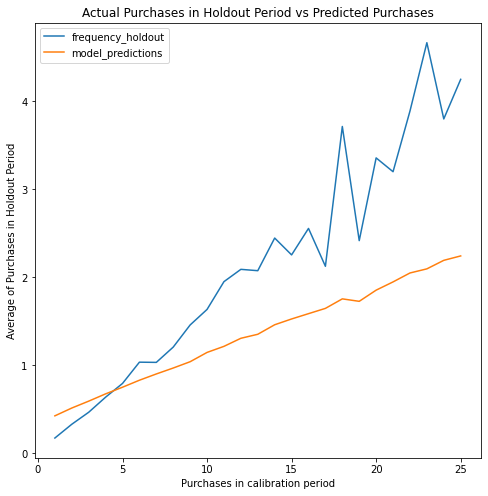

In [22]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(
  model, 
  input_pd, 
  n=90,
  **{'figsize' : (8,8)}
  )

display()

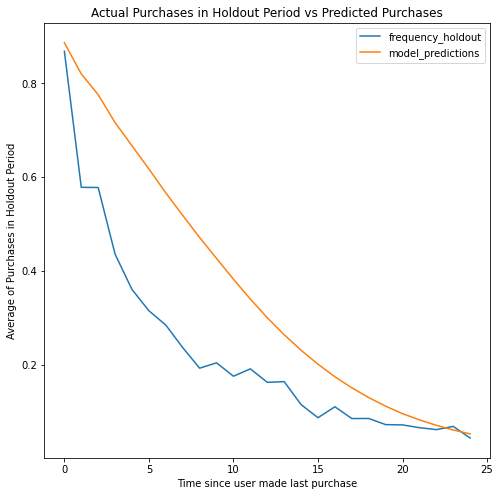

In [23]:
plot_calibration_purchases_vs_holdout_purchases(
  model, 
  input_pd, 
  kind='time_since_last_purchase', 
  n=90, 
  **{'figsize':(8,8)}
  )

display()

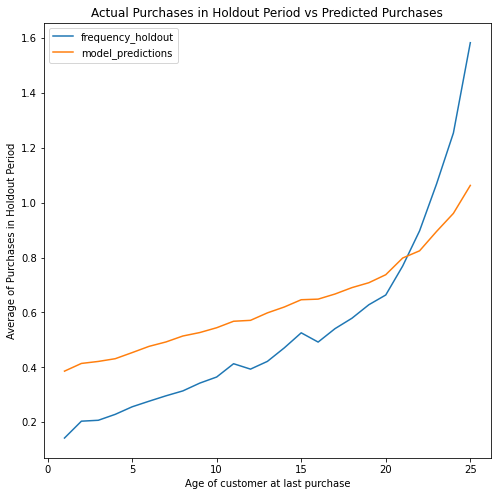

In [24]:
plot_calibration_purchases_vs_holdout_purchases(
  model, 
  input_pd, 
  kind='recency_cal', 
  n=300,
  **{'figsize':(8,8)}
  )

display()

In [25]:
# add a field with the probability a customer is currently "alive"
filtered_pd['prob_alive']=model.conditional_probability_alive(
    filtered_pd['frequency'], 
    filtered_pd['recency'], 
    filtered_pd['T']
    )

filtered_pd.head(10)

,frequency,recency,T,monetary_value,prob_alive
user_id,,,,,
10280338,1.0,4.0,19.0,76.030000,0.329522
12961898,4.0,14.0,18.0,68.192500,0.849565
13898969,1.0,7.0,22.0,11.730000,0.347724
20554973,3.0,8.0,17.0,113.656667,0.574146
23633626,1.0,1.0,4.0,38.810000,0.896252
25300038,3.0,11.0,25.0,169.066667,0.334541
27505098,1.0,8.0,11.0,15.760000,0.899954
27700601,1.0,13.0,25.0,8.970000,0.502591
27872944,3.0,19.0,20.0,28.326667,0.970285


/usr/local/lib/python3.7/dist-packages/scipy/special/_logsumexp.py:110: RuntimeWarning: overflow encountered in exp
  tmp = b * np.exp(a - a_max)


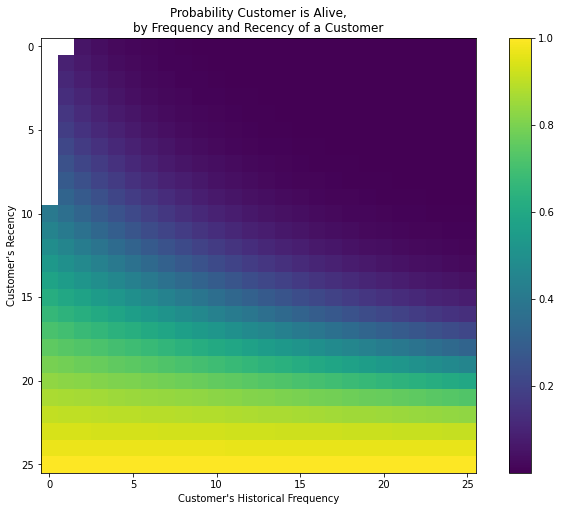

In [26]:
from lifetimes.plotting import plot_probability_alive_matrix

# set figure size
plt.subplots(figsize=(12, 8))

plot_probability_alive_matrix(model)

display()

/usr/local/lib/python3.7/dist-packages/scipy/special/_logsumexp.py:110: RuntimeWarning: overflow encountered in exp
  tmp = b * np.exp(a - a_max)
/usr/local/lib/python3.7/dist-packages/lifetimes/fitters/pareto_nbd_fitter.py:216: RuntimeWarning: invalid value encountered in logaddexp
  A_2 = logaddexp(-(r + x) * log(alpha + T) - s * log(beta + T), log(s) + log_A_0 - log(r_s_x))


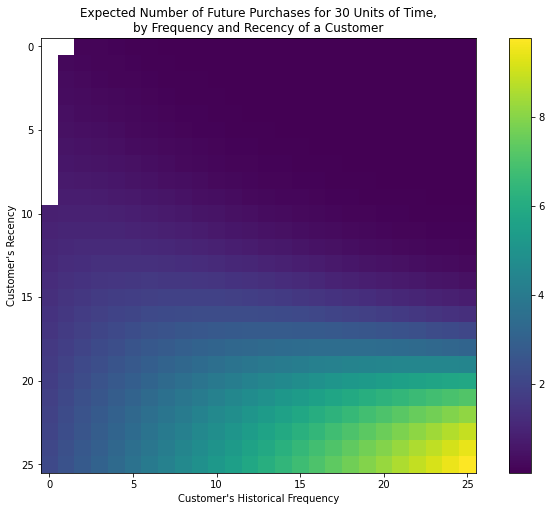

In [27]:
from lifetimes.plotting import plot_frequency_recency_matrix

# set figure size
plt.subplots(figsize=(12, 8))

plot_frequency_recency_matrix(model, T=30)

display()

In [28]:
filtered_pd['purchases_next30days']=(
  model.conditional_expected_number_of_purchases_up_to_time(
    30, 
    filtered_pd['frequency'], 
    filtered_pd['recency'], 
    filtered_pd['T']
    )
  )

filtered_pd.head(10)

,frequency,recency,T,monetary_value,prob_alive,purchases_next30days
user_id,,,,,,
10280338,1.0,4.0,19.0,76.030000,0.329522,0.886972
12961898,4.0,14.0,18.0,68.192500,0.849565,3.194761
13898969,1.0,7.0,22.0,11.730000,0.347724,0.891882
20554973,3.0,8.0,17.0,113.656667,0.574146,1.996595
23633626,1.0,1.0,4.0,38.810000,0.896252,3.204618
25300038,3.0,11.0,25.0,169.066667,0.334541,1.023819
27505098,1.0,8.0,11.0,15.760000,0.899954,2.790233
27700601,1.0,13.0,25.0,8.970000,0.502591,1.231117
27872944,3.0,19.0,20.0,28.326667,0.970285,3.210082


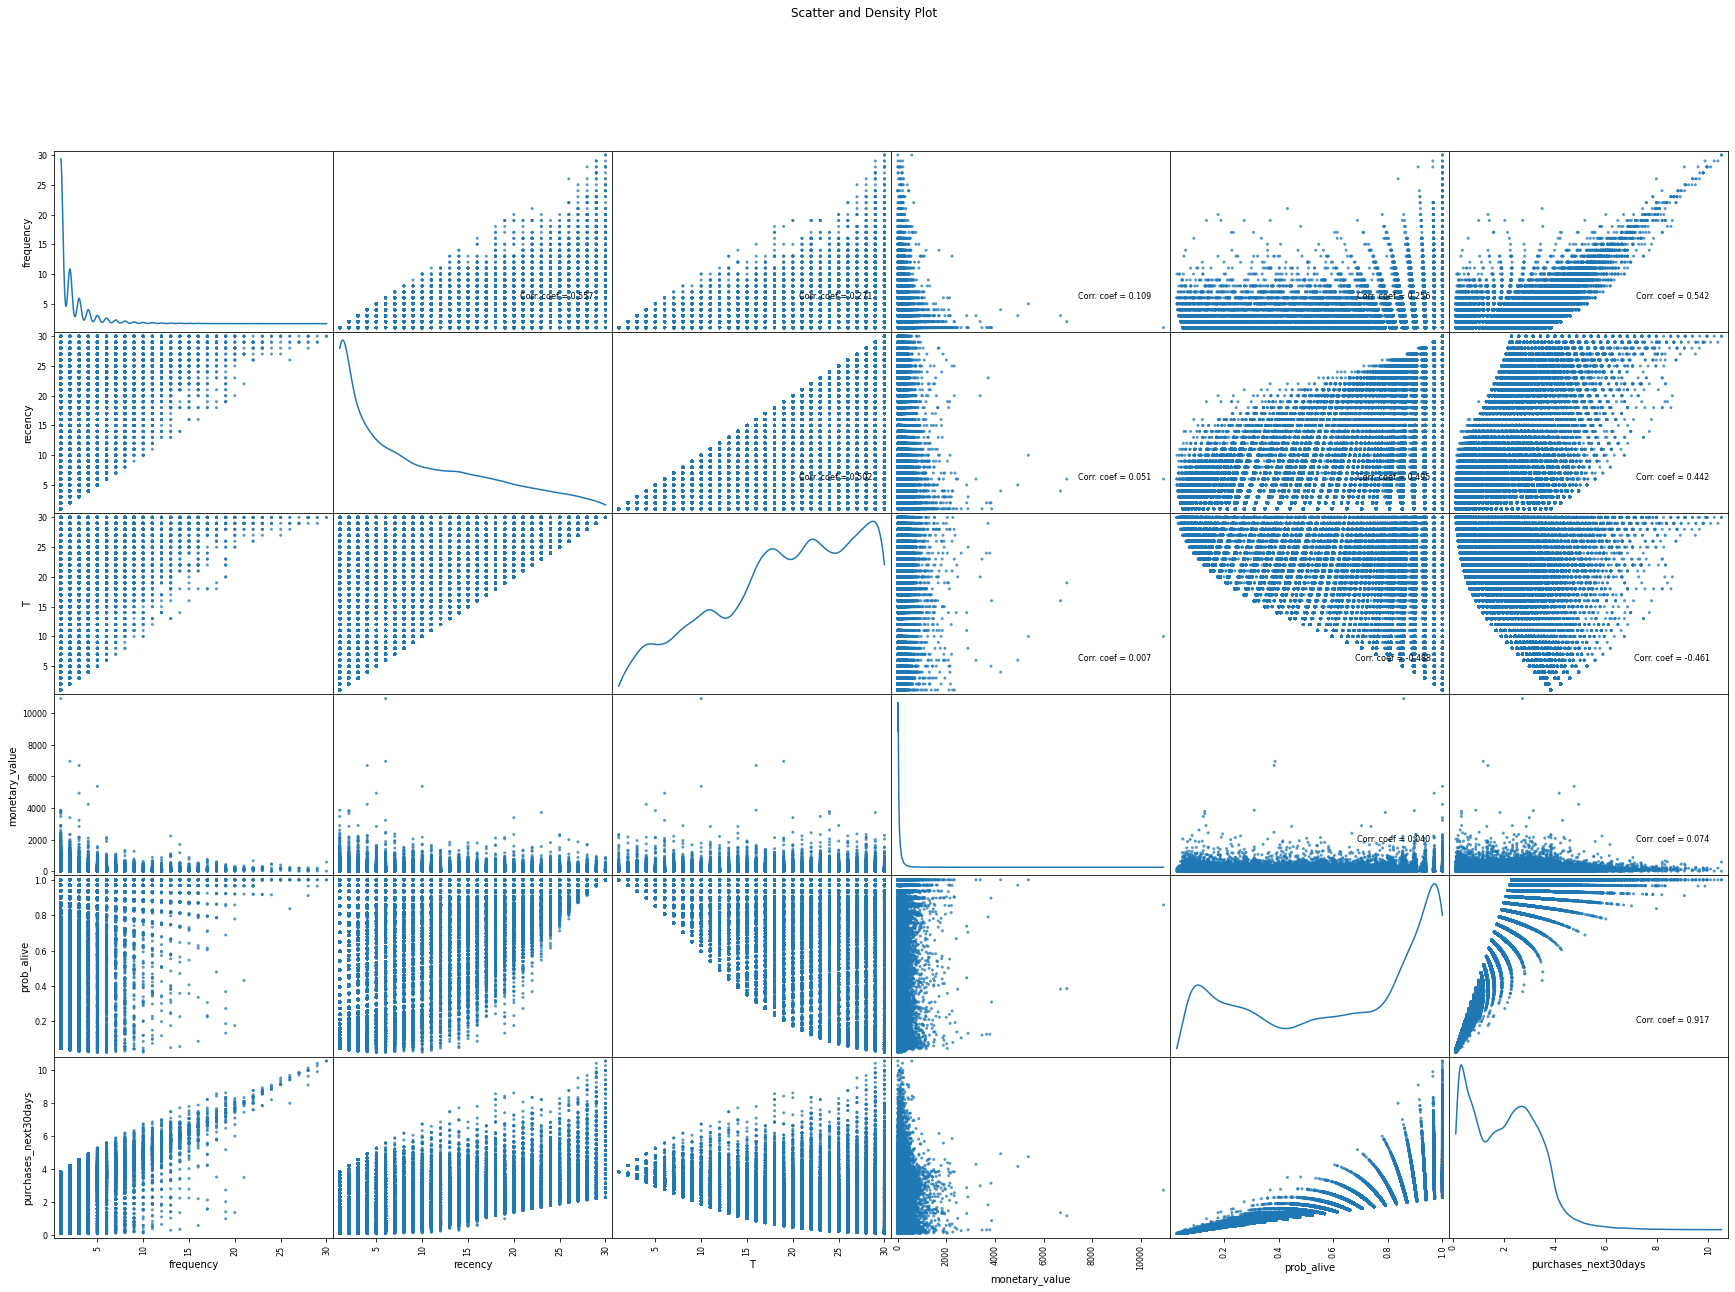

In [32]:
df = filtered_pd
ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[30, 20], diagonal='kde')
corrs = df.corr().values
for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
   ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=8)
plt.suptitle('Scatter and Density Plot')
plt.show()

In [34]:
model.save_model('/content/drive/My Drive/FourthBrain/Capstone Project/model_output/lifetimes_paretonbdfitter.pkl', save_data=True, save_generate_data_method=True)